<a href="https://colab.research.google.com/github/leabizbille/ProjetIOT/blob/main/Marc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [160]:
!pip install summarytools -q

In [161]:
!pip install pygwalker -q

In [162]:
pip install sweetviz -q

In [163]:
import pygwalker as pyg
from summarytools import dfSummary # module pandas-profiling
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv # Module pour faire le rapport HTML
import missingno as msno # observer les données manquantes
from google.colab import files # Exporter en cvs

import numpy as np
from scipy import stats #
import statsmodels.api as sm #
from statsmodels.formula.api import ols #
import plotly.graph_objects as go

In [164]:
# Charger le fichier CSV en conservant les titres des colonnes
Marc= pd.read_csv("/content/Marc_SmartOme.csv",sep= ";")


<Axes: >

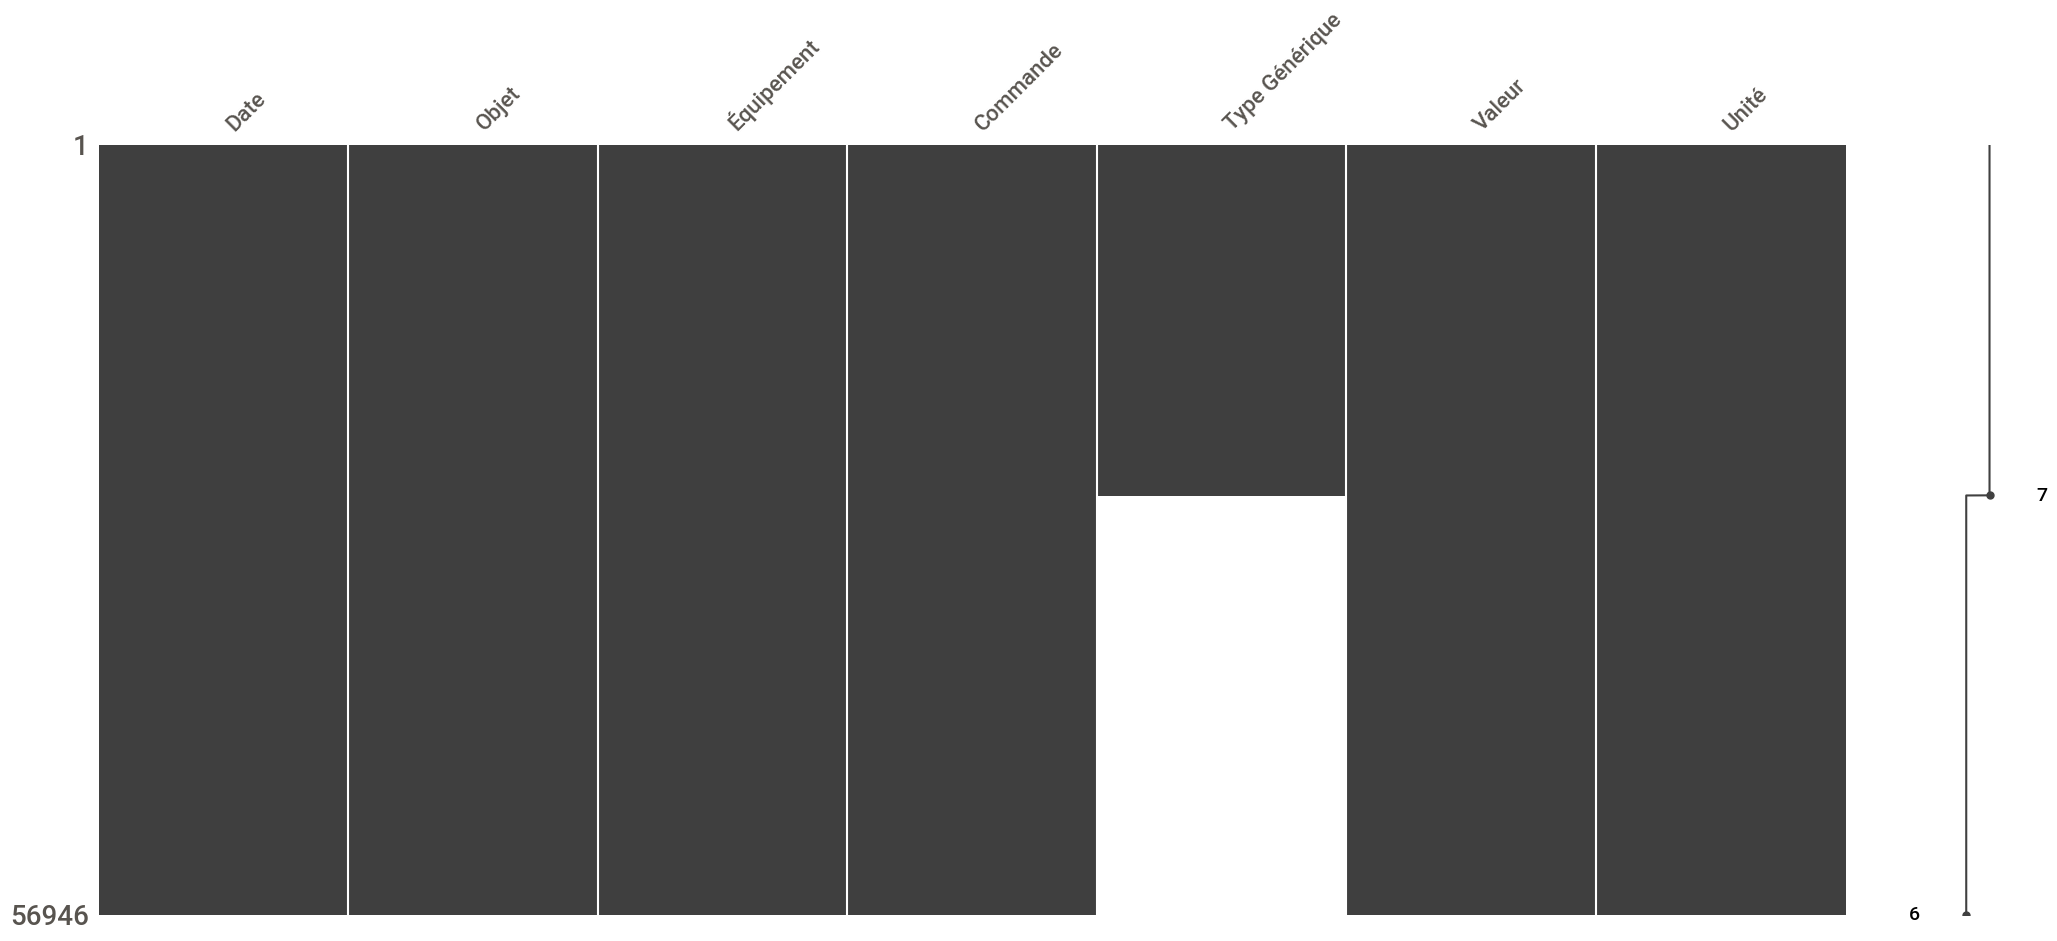

In [165]:
msno.matrix(Marc)

In [166]:
# Description pour comprendre les données et mettre en suite le tableau en forme
dfSummary(Marc)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Date[object],1. 2024-04-30 02:00:002. 2024-02-24 06:00:003. 2024-04-18 02:00:004. 2024-04-10 02:00:005. 2024-05-21 02:00:006. 2024-03-05 10:00:007. 2024-03-21 06:00:008. 2024-04-19 02:00:009. 2024-04-26 02:00:0010. 2024-05-17 02:00:0011. other,"11 (0.0%)10 (0.0%)10 (0.0%)10 (0.0%)10 (0.0%)10 (0.0%)10 (0.0%)10 (0.0%)10 (0.0%)10 (0.0%)56,845 (99.8%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,Objet[object],1. TECHNIQUE2. OPENSPACE3. BUREAU 1 (MARC)4. CUISINE5. BUREAU 2 (ARCHIVES),"30,991 (54.4%)8,620 (15.1%)8,302 (14.6%)6,867 (12.1%)2,166 (3.8%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABzCAYAAACPdnBjAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACM0lEQVR4nO3bQWrbUBiF0V/FhGYiYQxejBfRxXYR2o0x1qAJmaiDQghu7Eyerlz3nBU8zIeMxLvdPM8FCd/WPgD/D7ERIzZiuqp6rqqntQ/yQN7meX5Z+xD3aLPb7X70fb9d+yCPYpqmU9d1PwX3t03f99vD4fAyDMPr2of5153P5+/jOG6Px+NTVYntwqaqahiG1/1+/2vtwzyI57UPcK+8IBAjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMZuqP1dj1j7II/A73raZpuk0juO2XI1pYpqmU1W9rX2Oe+RaeHuuhV/R2Y2S4gWBmKX/Rv2l8G7RdZWlER8ttq6yNOLS0usqn1N45wWBGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IhZbF1lacSlRddVlkZ85Fo4MdZVxHhBIMbfKDHWVcRYVxFjXUWMFwRixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI8a6ihjrKmJcCyfGuoqY1k82TzKuajp4MXDhlmaDFwMXvtJ68GLgwlU+6hIjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjptm6ypqKrzRdV1lTcYsNAjHWVcTcerJ5StHU1XWVpRStfbquspRiCbfWVZZSNOWjLjFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZiPl1XWUqxhKvrKkspWrNBIMa6ihgvCMSIjZjfxzEON3LH9zwAAAAASUVORK5CYII="">",0(0.0%)
3,Équipement[object],1. TIC 1 (Suivi Conso Elec)2. Thermostat Open Space Z23. Thermostat Marc Z34. Thermostat Cuisine Z65. AIRZONE (Suivi Conso Elec)6. PAC (Suivi Conso Elec)7. Thermostat Archive Z58. APPOINT ELECTRIQUE (Suivi Cons,"18,514 (32.5%)8,620 (15.1%)8,302 (14.6%)6,867 (12.1%)6,807 (12.0%)5,302 (9.3%)2,166 (3.8%)368 (0.6%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAC4CAYAAAD0WZ4UAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADJklEQVR4nO3dXWoTUQCG4RMJojcJIdDFdBEu1kVkN6U0FyrexAt/EGkiTWbesfg8KzgXL6edYb52dTqdBhTeLH0A/h9iIyM2MmIjIzYyYiOzGmO8H2O8XfogE/h6Op0+L30Izlvv9/sPm81mt/RBbnU8Hh9Xq9VHwf271pvNZnd/f/95u91+Wfow13p6enp3OBx2Dw8Pb8cYYvtHrccYY7vdfrm7u/u09GFu9H7pA3CZBwQyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy6zG+f6Kz9EFu8drP/79YH4/Hx8PhsBuv/BOd4/H4OMb4uvQ5OM9n4WRW/vwClblvNrcNv8w6eDFC4XezDV6MUPjT3IOXV/2Ey7S81CUjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMz2+DFCIU/zTp4MULhdz4LJ2PwQsYDAhk/RslYV5GxriJjXUXGAwIZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVkfBZOxrqKzNQ3m5uMsyYdvBi4cMlkgx

- Valeurs contiennent différents type.
- 54 % de donnée manquante dans "Type Générique". Chercher l'utilisation et analyse l'interet.

Pour toutes les colonnes, reformater les données.
Un pivotement ou une transposition du tableau sera probablement nécessaire.

Mélange des modalites entre pièces et type d équipement

In [167]:
# Séparer la colonne 'datetime' en deux colonnes distinctes
Marc[['date', 'time']] = Marc['Date'].str.split(' ', expand=True)

# Convertir les nouvelles colonnes au format datetime
Marc['date'] = pd.to_datetime(Marc['date'], format='%Y-%m-%d')
Marc['time'] = pd.to_datetime(Marc['time'], format='%H:%M:%S').dt.time


In [168]:
# Ajouter une colonne 'Mois' pour extraire le mois (1-12)
Marc['Mois'] = Marc['date'].dt.month

In [169]:
# Ajouter une colonne 'Semaine' pour extraire la semaine de l'année
Marc['Semaine'] = Marc['date'].dt.isocalendar().week

In [170]:
# Créer une colonne 'Année' si elle n'existe pas déjà
Marc['annee'] = Marc['date'].dt.year

In [171]:
# Vérifier si 'time' est déjà au format datetime.time
if isinstance(Marc['time'].iloc[0], datetime.time):
    time_column = Marc['time']  # Déjà au bon format
elif Marc['time'].dtype == 'object':
    # Si 'time' est une chaîne, convertir au format datetime.time
    time_column = pd.to_datetime(Marc['time']).dt.time
else:
    raise ValueError("Le format de la colonne 'time' n'est pas compatible.")

# Ajouter une colonne 'Jour/Nuit'
Marc['Jour/Nuit'] = np.where(
    (time_column >= datetime.time(20, 0)) | (time_column < datetime.time(8, 0)),
    'Nuit',
    'Jour'
)

In [172]:
# Ajouter une colonne 'Ete/Hiver' basée sur le mois (valeurs numériques)
Marc['Ete/Hiver'] = np.where(
    (Marc['Mois'] >= 5) & (Marc['Mois'] <= 9),  # Mois de mai (5) à septembre (9) inclus
    'Ete',  # Été
    'Hiver'  # Hiver
)

In [173]:
# Supprimer l'ancienne colonne si elle n'est plus nécessaire
Marc= Marc.drop(columns=['Type Générique'])

In [174]:
# Trouver toutes les modalités uniques dans la colonne 'Équipement'
modalites = Marc['Objet'].unique()

# Afficher les modalités
print(modalites)

['BUREAU 1 (MARC)' 'BUREAU 2 (ARCHIVES)' 'CUISINE' 'OPENSPACE' 'TECHNIQUE']


In [175]:
# Fonction de nettoyage
def nettoyer_Objet(data):
    if data == 'BUREAU 1 (MARC)': # Changement de nom
        return 'Bureau'
    elif data == 'BUREAU 2 (ARCHIVES)': # Changement de nom
        return 'Bureau'
    elif data == 'CUISINE':  # Clarifie
        return 'Cuisine'
    elif data == 'OPENSPACE':  # Clarifie
        return 'Open_Space'
    elif data == 'TECHNIQUE': # Changement de nom
        return 'Technique'
    else:
        return data  # Conserve les autres modalités intactes
# Appliquer la fonction de nettoyage à la colonne 'Objets'
Marc['Piece'] = Marc['Objet'].apply(nettoyer_Objet)

In [176]:
# Trouver toutes les modalités uniques dans la colonne 'Équipement'
modalites = Marc['Équipement'].unique()

# Afficher les modalités
print(modalites)

['Thermostat Marc Z3' 'Thermostat Archive Z5' 'Thermostat Cuisine Z6'
 'Thermostat Open Space Z2' 'AIRZONE (Suivi Conso Elec)'
 'APPOINT ELECTRIQUE (Suivi Conso)' 'PAC (Suivi Conso Elec)'
 'TIC 1 (Suivi Conso Elec)']


In [177]:
# Fonction de nettoyage
def nettoyer_type(data):
    if data == 'Thermostat Marc Z3': # Changement de nom
        return 'Thermostats'
    elif data == 'Thermostat Archive Z5': #
        return 'Thermostats'
    elif data == 'Thermostat Cuisine Z6':  #
        return 'Thermostats'
    elif data == 'Thermostat Open Space Z2':  #
        return 'Thermostats'
    elif data == 'AIRZONE (Suivi Conso Elec)': #
        return 'AirZone'
    elif data == 'APPOINT ELECTRIQUE (Suivi Conso)':  #
        return 'Appoint-Electrique'
    elif data == 'PAC (Suivi Conso Elec)':  #
        return 'Compteurs'
    elif data == 'TIC 1 (Suivi Conso Elec)':  #
        return 'Compteurs'
    else:
        return data  # Conserve les autres modalités intactes
# Appliquer la fonction de nettoyage à la colonne 'Objets'
Marc['Objet'] = Marc['Équipement'].apply(nettoyer_type)

In [178]:
# Fonction de nettoyage
def nettoyer(data):
    if data == 'Thermostat Marc Z3': # Changement de nom
        return 'Z3'
    elif data == 'Thermostat Archive Z5': # Changement de nom
        return 'Z5'
    elif data == 'Thermostat Cuisine Z6':  # Clarifie
        return 'Z6'
    elif data == 'Thermostat Open Space Z2':  # Clarifie
        return 'Z2'
    elif data == 'AIRZONE (Suivi Conso Elec)': # Changement de nom
        return 'AirZone'
    elif data == 'APPOINT ELECTRIQUE (Suivi Conso)':  # Clarifie
        return 'Appoint-Electrique'
    elif data == 'PAC (Suivi Conso Elec)':  # Clarifie
        return 'PAC'
    elif data == 'TIC 1 (Suivi Conso Elec)':  # Clarifie
        return 'TIC'
    else:
        return data  # Conserve les autres modalités intactes
# Appliquer la fonction de nettoyage à la colonne 'Objets'
Marc['Réplicat'] = Marc['Équipement'].apply(nettoyer)

In [179]:
# Fonction de nettoyage
def nettoyer_Equipement(data):
    if data.startswith('Thermostat'):
        return 'Thermostat'
    else :
        return 'Conso_Objet'
    return data

# Appliquer la fonction de nettoyage à la colonne 'Objets'
Marc['Équipement'] = Marc['Équipement'].apply(nettoyer_Equipement)

In [180]:
# Description pour comprendre les données et mettre en suite le tableau en forme
#dfSummary(Marc)

In [181]:
# Trouver toutes les modalités uniques dans la colonne 'Équipement'
modalites = Marc['Commande'].unique()

# Afficher les modalités
print(modalites)

['Température ambiante' 'Consommation jour' 'Consommation mois']


In [182]:
def nettoyer_Commande(data):
    data = data.strip()  # Supprime les espaces au début et à la fin
    if data.startswith('Température ambiante'):
        return 'Température'
    elif data == 'Consommation jour':  # Nettoie "Conso "
        return 'Conso_jour'
    elif data == 'Consommation mois':
        return 'Conso_mois'
    else:
        return data  # Conserve les autres modalités intactes

# Appliquer la fonction de nettoyage à la colonne Equipement
Marc['Commande'] = Marc['Commande'].apply(nettoyer_Commande)

In [183]:
Marc['Valeur'] = pd.to_numeric(Marc['Valeur'].str.replace(',', '.'), errors='coerce')

In [184]:
print(Marc.isna().sum())

Date          0
Objet         0
Équipement    0
Commande      0
Valeur        0
Unité         0
date          0
time          0
Mois          0
Semaine       0
annee         0
Jour/Nuit     0
Ete/Hiver     0
Piece         0
Réplicat      0
dtype: int64


Rapport des données nettoyées :

In [185]:
#my_report = sv.analyze(Marc)

In [186]:
#my_report.show_html()

Rapport des données de Val Roland, binaire entre les appartements les T°C et les conso

In [187]:
#my_report = sv.compare_intra(Marc, Marc["Unité"] == "kWh", ["Consommation", "Température"])

In [188]:
#my_report.show_html()

<Axes: >

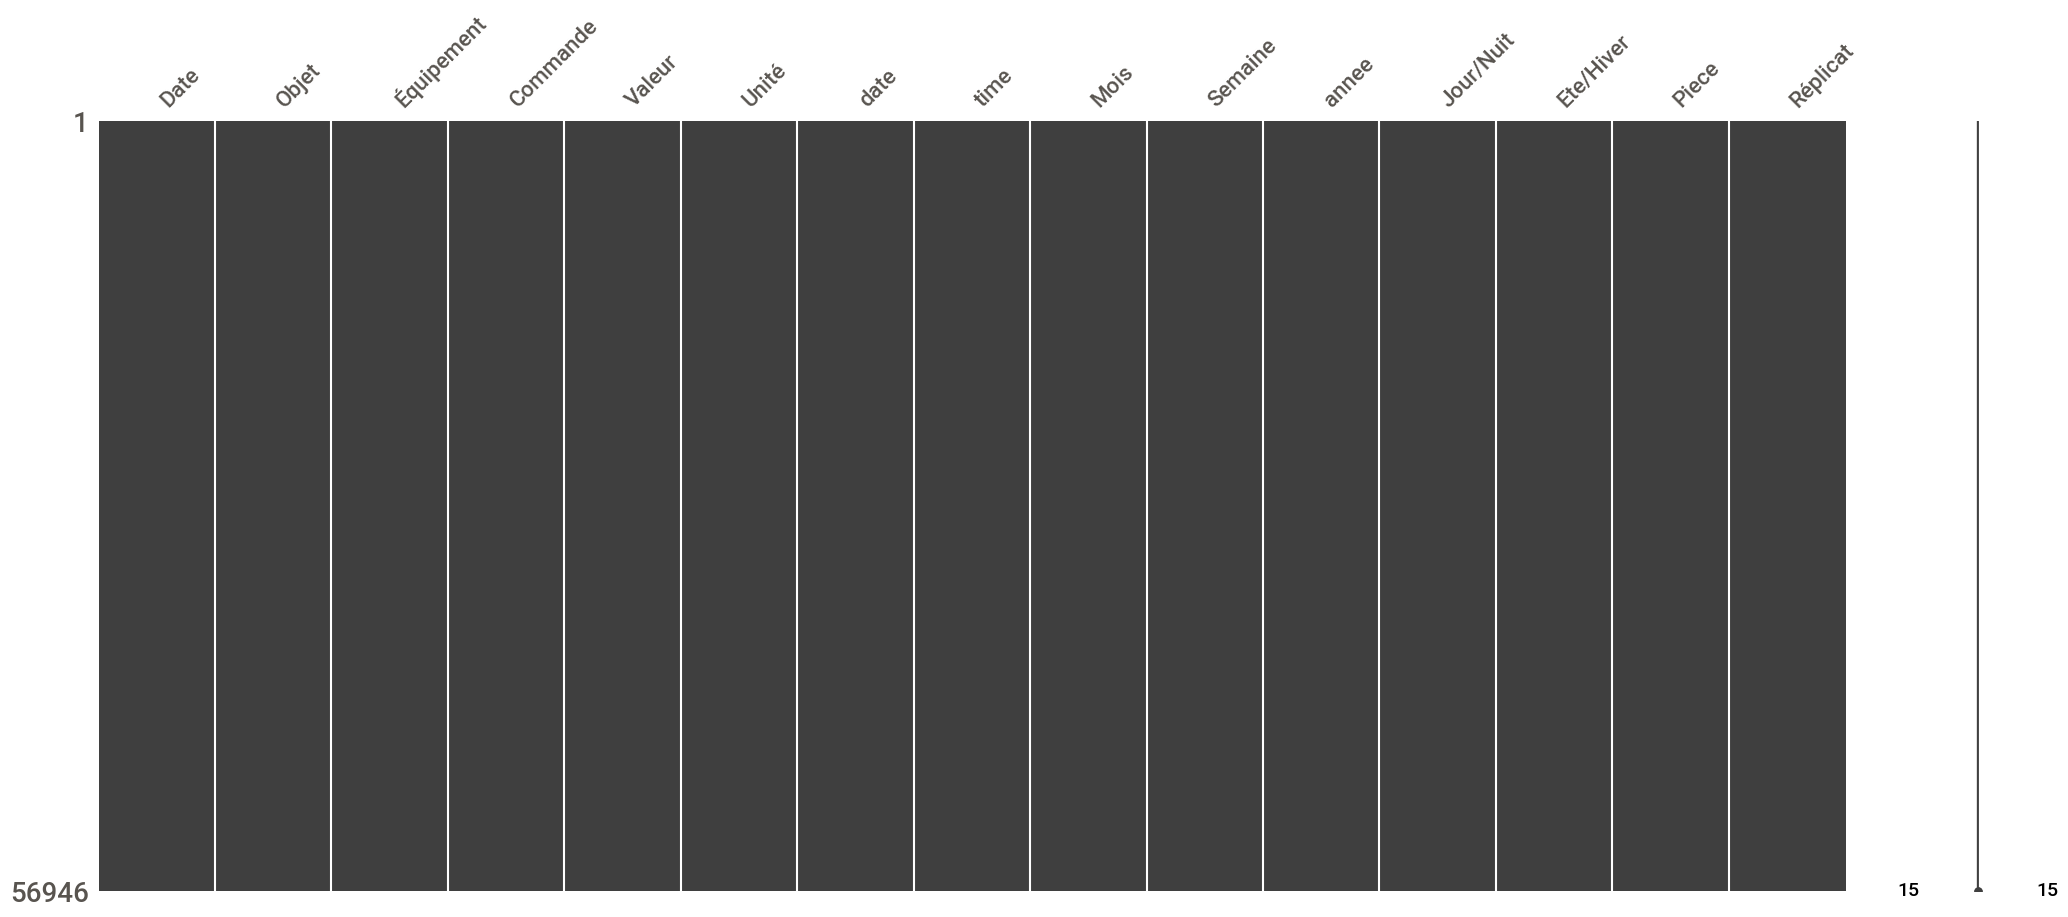

In [189]:
msno.matrix(Marc)

In [190]:
# Sauvegarder le DataFrame en tant que fichier CSV
#Marc.to_csv('Marc_export.csv', index=False)

# Télécharger le fichier dans votre machine locale
#files.download('Marc_export.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [196]:
# Filtrer les données pour "Unité" en °C
data_celsius = Marc[Marc['Unité'] == '°C']  # Vérifier que 'Unité' est bien une chaîne

In [ ]:
print(data_celsius)

KeyboardInterrupt: 

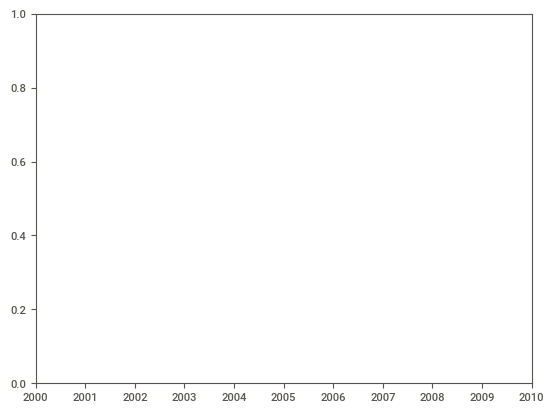

In [201]:
import seaborn as sns


# Utiliser Seaborn pour tracer toutes les courbes en une seule commande
sns.lineplot(
    data=data_celsius,
    x='date',
    y='Valeur',
    hue='Réplicat',  # Différencier les courbes par réplicat
    palette='tab10'
)

# Ajouter des labels et une légende
plt.title("Évolution des températures par pièce", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Température (°C)", fontsize=14)
plt.legend(title="Pièce", loc='upper left', fontsize=10)
plt.grid(True)

# Ajuster les dates pour qu'elles soient lisibles
plt.xticks(rotation=45, ha='right')

# Afficher le graphique
plt.tight_layout()
plt.show()



Probleme avec la sonde 5 !

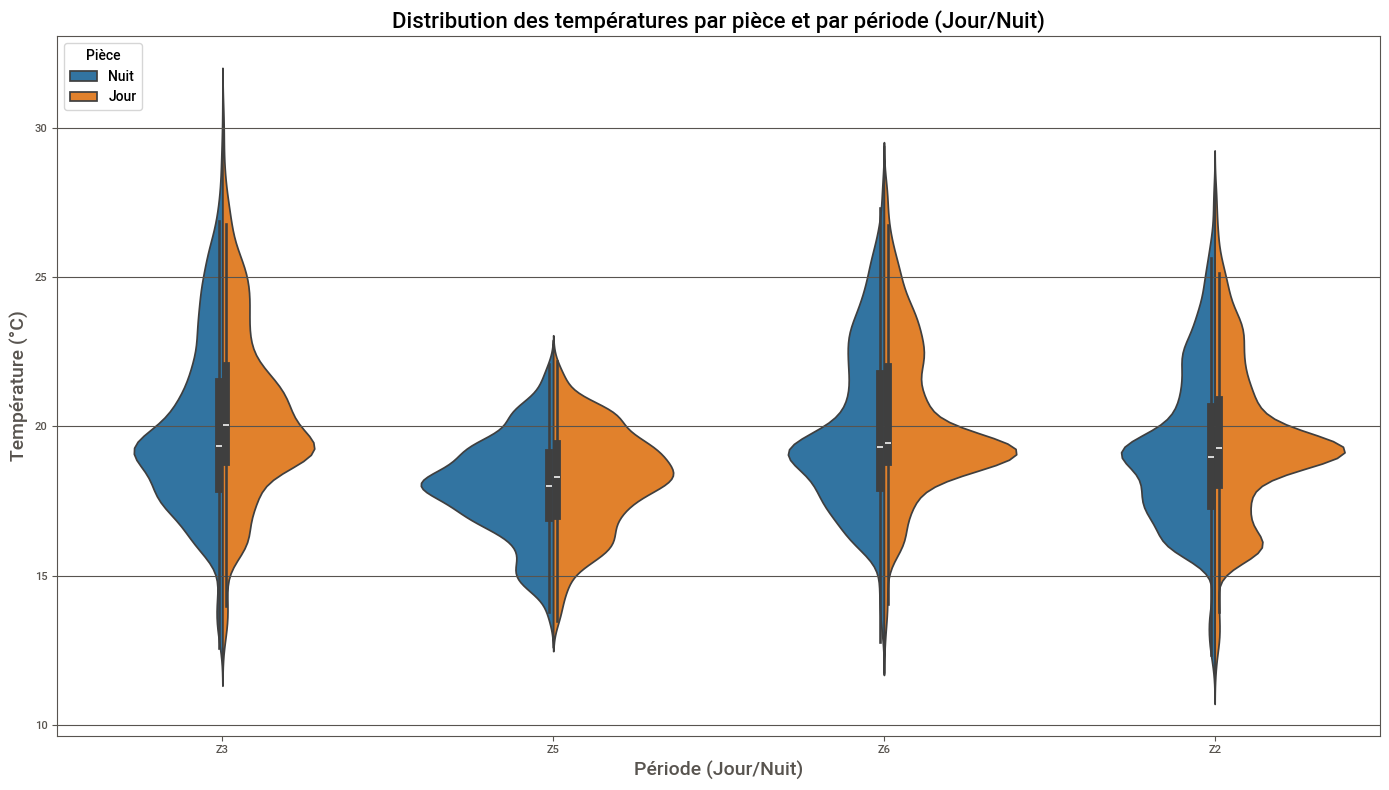

In [205]:

# Initialiser le graphique
plt.figure(figsize=(14, 8))

# Tracer un graphique en violon
sns.violinplot(
    data=data_celsius,
    x='Réplicat',  # Axe catégoriel
    y='Valeur',     # Température
    hue='Jour/Nuit',  # Différencier par réplicat
    split=True,     # Diviser les violons pour chaque réplicat
    palette='tab10'
)

# Ajouter des labels et une légende
plt.title("Distribution des températures par pièce et par période (Jour/Nuit)", fontsize=16)
plt.xlabel("Période (Jour/Nuit)", fontsize=14)
plt.ylabel("Température (°C)", fontsize=14)
plt.legend(title="Pièce", loc='upper left', fontsize=10)
plt.grid(True, axis='y')

# Afficher le graphique
plt.tight_layout()
plt.show()


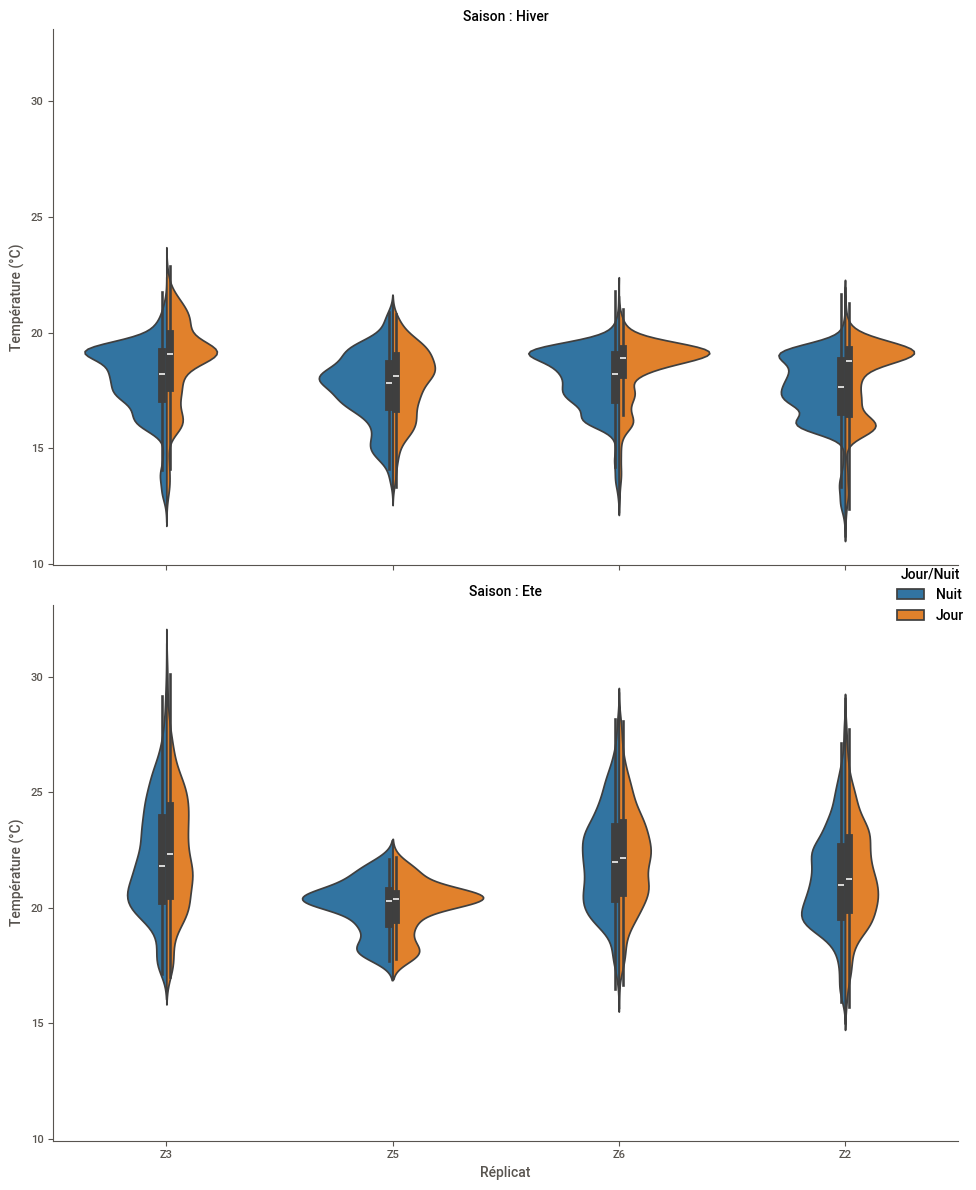

In [208]:


# Initialiser une grille de facettes avec "Été/Hiver"
g = sns.FacetGrid(data_celsius, col="Ete/Hiver", col_wrap=1, height=6, aspect=1.5)

# Ajouter un graphique en violon à chaque facette
g.map_dataframe(
    sns.violinplot,
    x="Réplicat",  # Axe catégoriel
    y="Valeur",    # Température
    hue="Jour/Nuit",  # Différencier les périodes Jour/Nuit
    split=True,    # Diviser les violons pour chaque catégorie
    palette="tab10"
)

# Ajouter des ajustements
g.set_titles("Saison : {col_name}")
g.set_axis_labels("Réplicat", "Température (°C)")
g.add_legend(title="Jour/Nuit")

# Ajuster l'affichage et montrer
plt.tight_layout()
plt.show()
